# Logistic regression

### Outline
In this notebook, we do the following:
1. Cover logistic regression for binary classification
2. Cover logistic regression for multiclass classification


## Logistic regression for binary classification

### Setup
As usual, we are given a labelled dataset for binary classification with the following form:
- There are $m$ instances in the dataset. 
- There are $n$ features $X_i$, each corresponding to a column vector $\mathbf{x}_i \in \mathbb{R}^m$. 
- There is a single binary target $Y$ which takes the value $0$ or $1$ for each instance. The target is represented by a column vector $\mathbf{y} \in \{0,1\}^m$.
We write $\vec{x}_i$ for the $i$-th row of the feature matrix $\mathbf{X}$.

### Recall the perceptron
Recall that the perceptron is a linear classifier which picks out a single hyperplane in the feature space $\mathbb{R}^n$ to separate the two classes, i.e. for all instances $\vec{x}$ lying on one side of the hyperplane, the perceptron predicts $0$, and for all instances on the other side, it predicts $1$.

The parameters of the perceptron consist of a weight vector $\vec{w} \in \mathbb{R}^n$ and bias $b \in \mathbb{R}$. The hyperplane dividing the two classes is defined by the equation $\vec{w} \cdot \vec{x} + b = 0$. In the other words, the set of points lying on the hyperplane is:
\begin{equation*}
    \{ \vec{x} \in \mathbb{R}^n \mid \vec{w} \cdot \vec{x} + b = 0 \}.
\end{equation*}
(We saw last time that this is an affine space that is parallel to the subspace of vectors orthogonal to $\vec{w}$.) 

Now, the perceptron $P_{\vec{w},b}$ is defined as:
\begin{align*}
    P_{\vec{w},b}(\vec{x}) & = p(1\mid \vec{x})\\
    & = H(\vec{w} \cdot \vec{x} + b) = 
    \begin{cases}
        1 & \text{if } \; (\vec{w} \cdot \vec{x} + b) > 0, \\
        0 & \text{if } \; (\vec{w} \cdot \vec{x} + b) < 0.
    \end{cases}
\end{align*}
Above, $H$ is the Heaviside step function. The notation $p(1\mid \vec{x})$ is used to denote the probability of the instance $\vec{x}$ belonging to class $1$. (That is, it is the conditional probability that $Y=1$ given that the features are $\vec{x}$.)

Recall that the parameters $(\vec{w},b)$ are learned via the perceptron algorithm, which starts by initializing arbitrary weights, and then iteratively updates them by looking at the misclassified instances. The algorithm terminates when all the instances are correctly classified, or after a fixed number of iterations (determined by the user at the beginning). 

### Softening the perceptron
The perceptron is hard classifier, i.e. it only outputs $0$ or $1$. We turn now to the problem of converting it into a soft classifier, i.e. one the outputs a pair of real numbers $(p_0,p_1)$, where $p_0$ is the probability that the instance belongs to class $0$, and $p_1$ is the probability that it belongs to class $1$. Since $p_0 + p_1 = 1$, we can equivalently output just $p_1$.

That is, we want to construct a function $L_{\vec{w},b} : \mathbb{R}^n \to [0,1]$ such that $L_{\vec{w},b}(\vec{x})$ is the probability that the instance $\vec{x}$ belongs to class $1$:
\begin{equation*}
    L_{\vec{w},b}(\vec{x}) = p(1\mid \vec{x}).
\end{equation*}

To accomplish this, we can leave the linear part of the function alone and try to modify the thresholding part (the Heaviside function) to something that is not so jumpy. To set this up, let $z$ denote the output of the linear part, i.e.
\begin{equation*}
    z = \vec{w} \cdot \vec{x} + b.
\end{equation*}
Then, our perceptron can be written as:
\begin{equation*}
    P_{\vec{w},b}(\vec{x}) = p(1\mid \vec{x}) = H(z).
\end{equation*}
We want to replace the Heaviside function $H(z)$ with a function $L(z)$ that is continuous and smooth, and that satisfies the following properties:
1. $L(z) \in (0,1)$ for all $z \in \mathbb{R}$ (i.e. $L$ is a probability).
2. $L(z)$ is a monotonically increasing function of $z$ (i.e. $L$ squishes the entire $z$-line into the interval $(0,1)$, and it does it in such a way that if $z_1 < z_2$ then $L(z_1) < L(z_2)$).
3. $L(z)$ is smooth (i.e. differentiable) everywhere. (This is not strictly necessary, but it will be useful later on, when we will want to use gradient descent to learn the parameters.)
4. $L(0) = 0.5$ (i.e. the predicted probability of being in class $1$ is $0.5$ for points $\vec{x}$ lying on the dividing hyperplane $z = 0$; in some sense, this is saying that the hyperplane is the "equilibrium" point between the two classes, with maximum uncertainty).

### Sigmoid function(s)
There is a parametric class of functions that satisfy all of the above properties; they are called **sigmoid functions**:
\begin{equation*}
    \sigma(z) = \frac{1}{1 + e^{-Tz}},
\end{equation*}
where $T > 0$ is a parameter that controls the steepness of the function. The most common choice is $T = 1$, in which case we write $\sigma(z) = \frac{1}{1 + e^{-z}}$ and call it the **logistic function**.

Thus, putting it all together, we define the **logistic regression model** as:
\begin{align*}
    L_{\vec{w},b}(\vec{x}) &= p(1\mid \vec{x}) \\
    &= \frac{1}{1 + \exp{-(z)}},
\end{align*}
where $z = \vec{w} \cdot \vec{x} + b$.

In the plot below, we compare the Heaviside and sigmoid functions. Note that all four properties above are preserved as we vary the slider for $T$. The only thing that changes is how fast the sigmoid function goes from $0$ to $1$ as $z$ increases from $-\infty$ to $+\infty$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

def create_plots(T=1.0):
    # Create figure with two subplots side by side using plt.subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Create x values
    x = np.linspace(-10, 10, 1000)
    
    # First subplot: Heaviside function
    ax1.set_ylim(-0.2, 1.2)
    ax1.set_xlim(-10, 10)
    
    # Heaviside function
    heaviside = np.zeros_like(x)
    heaviside[x >= 0] = 1.0
    
    # Plot Heaviside in two colors
    ax1.plot(x[x<0], heaviside[x<0], 'steelblue', linewidth=2)
    ax1.plot(x[x>=0], heaviside[x>=0], 'indianred', linewidth=2)
    
    # Horizontal and vertical lines
    ax1.axhline(y=0.5, color='black', linestyle='--', alpha=0.7)
    ax1.axvline(x=0, color='black', linestyle='--', alpha=0.7)
    
    # Set labels and grid style
    ax1.set_title('Heaviside Step Function', fontsize=14)
    ax1.set_xlabel('z', fontsize=12)
    ax1.set_ylabel('H(z)', fontsize=12)
    ax1.grid(True, color='white', linestyle='-', linewidth=0.7, alpha=0.3)
    ax1.set_facecolor('#f8f8f8')
    
    # Second subplot: Sigmoid function with color map
    ax2.set_ylim(-0.2, 1.2)
    ax2.set_xlim(-10, 10)
    
    # Sigmoid function
    sigmoid = 1 / (1 + np.exp(-T * x))
    
    # Create a scatter plot with colors based on y-value
    cmap = plt.get_cmap('coolwarm')
    scatter = ax2.scatter(x[::20], sigmoid[::20], c=sigmoid[::20], cmap=cmap, 
                         s=30, alpha=0.8, vmin=0, vmax=1)
    
    # Add a colorbar
    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label('Sigmoid Value', rotation=270, labelpad=20)
    
    # Plot the sigmoid line
    ax2.plot(x, sigmoid, 'k-', alpha=0.5, linewidth=1.5)
    
    # Horizontal and vertical lines
    ax2.axhline(y=0.5, color='black', linestyle='--', alpha=0.7)
    ax2.axvline(x=0, color='black', linestyle='--', alpha=0.7)
    
    # Set labels and grid style
    ax2.set_title(f'Sigmoid Function: 1/(1 + e^(-T·z)) with T = {T:.2f}', fontsize=14)
    ax2.set_xlabel('z', fontsize=12)
    ax2.set_ylabel('σ(z)', fontsize=12)
    ax2.grid(True, color='white', linestyle='-', linewidth=0.7, alpha=0.3)
    ax2.set_facecolor('#f8f8f8')
    
    plt.tight_layout()
    plt.show()

# Create an interactive widget
interact(
    create_plots,
    T=FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0, description='T:')
)

interactive(children=(FloatSlider(value=1.0, description='T:', max=5.0, min=0.1), Output()), _dom_classes=('wi…

<function __main__.create_plots(T=1.0)>

Let's compare the outputs of a Perceptron and Logistic Regression model for a binary classification task. Namely, we try to predict whether `target` is `1` or `0` to represent whether the particular county will vote in favor of the Democratic party or Republican part (for simplicity, we omit any third option). We use only the features `edu_low` and `marital_single`. To start, let's read in the data and display the dictionary to see what's in the dataset.

In [2]:
import pandas as pd
import json

# read in presidential election dataset
df_train = pd.read_csv('../data/classification/presidential_election_binary/train.csv')
df_test = pd.read_csv('../data/classification/presidential_election_binary/test.csv')

# read in the data_description json file as a dictionary
with open('../data/classification/presidential_election_binary/data_description.json') as f:
    data_description = json.load(f)
data_description

{'fips': 'Federal Information Processing Standard (FIPS) county code',
 'year': 'Election year',
 'area_sqmi': 'County area in square miles',
 'pop_density': 'Population density (people per square mile)',
 'income_median': 'Median household income',
 'income_percapita': 'Per capita income',
 'income_poverty': 'Population below poverty line',
 'income_10': 'Population with income below $10,000',
 'income_10-15': 'Population with income between $10,000-$15,000',
 'income_15-25': 'Population with income between $15,000-$25,000',
 'income_25': 'Population with income above $25,000',
 'pop_male': 'Proportion of male population',
 'pop_female': 'Proportion of female population',
 'hispanic': 'Proportion of Hispanic population',
 'labor_total': 'Proportion of working-age population',
 'labor_armed': 'Proportion in armed forces',
 'labor_employed': 'Proportion employed',
 'labor_unemployed': 'Proportion unemployed',
 'native_yes': 'Proportion of native-born citizens',
 'native_no': 'Proportion

Next, let's fit the model to the data with our chosen features. We will use the `LogisticRegression` class from `sklearn.linear_model`. The `fit` method will train the model on the data, and the `predict_proba` method will give us the predicted probabilities for each class (as opposed to the `predict` method, which outputs the predicted class labels).

In [3]:
# features = ['edu_low','edu_high','marital_single','marital_sepdiv', 'native_no','race_wht_total','race_blk_total','area_sqmi','pop_density','income_poverty','hispanic']

features = ['edu_low','marital_single']

# fit a logistic regression model with edu_low and marital_single as predictors
from sklearn.linear_model import LogisticRegression

# create the X and y matrices
X_train = df_train[features]
y_train = df_train['target']
X_test = df_test[features]
y_test = df_test['target']

# fit the model
model = LogisticRegression()
model.fit(X_train, y_train)

#display the coefficients
print('Coefficients:')
print('Intercept:', round(model.intercept_[0], 3))
print('edu_low:', round(model.coef_[0][0], 3))
print('marital_single:', round(model.coef_[0][1], 3))

# display the accuracies on the train and test sets
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)
print()
print('Train accuracy:', round(train_accuracy, 3))
print('Test accuracy:', round(test_accuracy, 3))

Coefficients:
Intercept: -5.252
edu_low: -2.4
marital_single: 17.729

Train accuracy: 0.826
Test accuracy: 0.821


Let $x_1$ and $x_2$ represent the features `edu_low` and `marital_single`, respectively. Then our logistic regression model is given by the parameters
\begin{equation*}
    \vec{w},b = (w_1,w_2,b) = (-2.4,17.729,-5.252).
\end{equation*}
In other words, the first linear part of the model is defined by
\begin{equation*}
    z = \vec{w} \cdot \vec{x} + b = -2.4x_1 + 17.729x_2 - 5.252.
\end{equation*}
The output of the logistic regression model (which uses the logistic function) is then given by
\begin{align*}
    L_{\vec{w},b}(\vec{x}) &= \frac{1}{1 + \exp(-z)} \\
    &= \frac{1}{1 + \exp{(2.4x_1 - 17.729x_2 + 5.252)}}.
\end{align*}
That is, given an instance $\vec{x} = (x_1,x_2)$, the predicted probability that the instance belongs to class $1$ (according to the model) is given by the above formula. 

NOTE: We can convert the logistic regression model back to the perceptron model by declaring the threshold to be $0.5$. That is, we can say that the perceptron predicts $1$ if $L_{\vec{w},b}(\vec{x}) >= 0.5$, and $0$ otherwise. By construction, these conditions are equivalent to $z >= 0$ and $z < 0$, respectively.

So, in this case, the perceptron model would therefore be given by
\begin{equation*}
    P_{\vec{w},b}(\vec{x}) = H(z) = 
    \begin{cases}
        1 & \text{if } \; -2.4x_1 + 17.729x_2 - 5.252 \geqslant 0, \\
        0 & \text{if } \; -2.4x_1 + 17.729x_2 - 5.252 < 0.
    \end{cases}
\end{equation*}

/opt/anaconda3/envs/math392/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


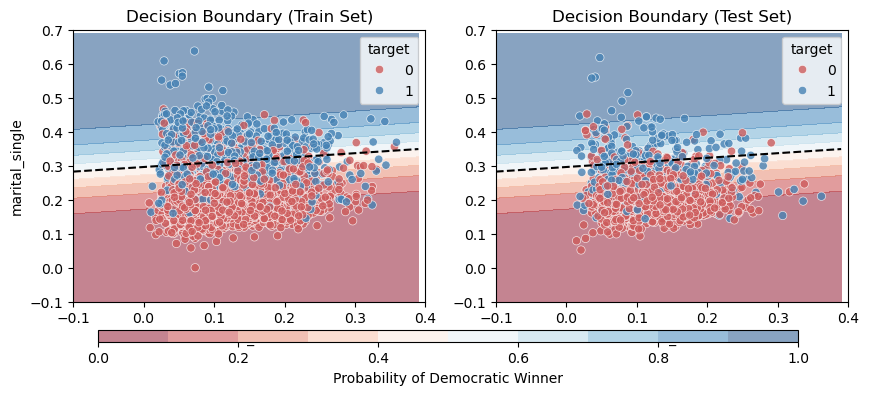

In [4]:
import seaborn as sns

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# Define color palette for visualization - blue for Democratic (1), red for Republican (0)
palette = {1: 'steelblue', 0: 'indianred'}

# Define the grid boundaries for visualization
x_min, x_max = -0.1, 0.4  # Range for edu_low
y_min, y_max = -0.1, 0.7  # Range for marital_single

# Create a mesh grid for calculating probabilities across the feature space
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Get probability predictions for each point in the grid
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]  
Z = Z.reshape(xx.shape)

# Plot training set
contour1 = ax1.contourf(xx, yy, Z, alpha=0.5, levels=np.linspace(0, 1, 11), cmap='RdBu')
ax1.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--')
sns.scatterplot(x='edu_low', y='marital_single', data=df_train, 
                alpha=0.8, hue='target', palette=palette, ax=ax1)
ax1.set_xlabel('edu_low')
ax1.set_ylabel('marital_single')
ax1.set_title('Decision Boundary (Train Set)')

# Plot test set
contour2 = ax2.contourf(xx, yy, Z, alpha=0.5, levels=np.linspace(0, 1, 11), cmap='RdBu')
ax2.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--')
sns.scatterplot(x='edu_low', y='marital_single', data=df_test, 
                alpha=0.8, hue='target', palette=palette, ax=ax2)
ax2.set_xlabel('edu_low')
ax2.set_ylabel('')  # Remove y-axis label from second subplot
ax2.set_title('Decision Boundary (Test Set)')

# Set identical axis limits for both plots
for ax in [ax1, ax2]:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

# Add a horizontal colorbar at the bottom
plt.subplots_adjust(bottom=0.2)  # Make room for the colorbar
cax = fig.add_axes([0.15, 0.1, 0.7, 0.03])  # [left, bottom, width, height]
cbar = plt.colorbar(contour1, cax=cax, orientation='horizontal', label='Probability of Democratic Winner')

plt.show()

In the above plots, we see the following:
- The axes represent our chosen features `edu_low` and `marital_single` (i.e. $x_1$ and $x_2$), so our plot is visualizing the data points living in the feature space spanned by $x_1$ and $x_2$ axis.
- The dots are colored blue for `1` and red for `0` (their true labels).
- The black dashed line represents the decision boundary of our logistic regression model; it consists of all points $\vec{x} = (x_1,x_2)$ such that
\begin{equation*}
    z = -2.4x_1 + 17.729x_2 - 5.252 = 0.
\end{equation*}
Equivalently, it is the set of points $\vec{x}$ such that $L_{\vec{w},b}(\vec{x}) = 0.5$.
- The color gradient in the background represents the predicted probabilities of the logistic regression model. Note that if we take any line parallel to the decision boundary, then the value of $z$ remains constant along the line, and so does the predicted probability $L_{\vec{w},b}(\vec{x})$.
- In general, given a point $\vec{x}$, we can interpret $z$ (more or less) as the orthogonal distance from $\vec{x}$ to the decision boundary. The further away $\vec{x}$ is from the decision boundary, the more certain the model is about its prediction, and as $z$ goes from $-\infty$ to $+\infty$, the predicted probability of being in class $1$ goes from $0$ to $1$.

**Warning**: The intuition behind the logistic regression model is that we should become more confident in our predictions the further away we are from the decision boundary. This is consistent with the kind of picture in which the cloud of red and blue dots are more or less separated, but have some overlap near the decision boundary. 

In practice, however, this may not always be the most logical way to model the situation.

For instance, in our current dataset, we in fact already have a way to measure the "true" probability of voting blue or red, namely, we can interpret the columns `dem` and `repub` (which represent the fraction of votes in favor of either party) as the true probabilities!

In the plot below, we use the true probabilities to color the points, and the background still represents the predicted probabilities. If our predicted probabilities were accuracte, then we should be seeing that the color gradients of the points should more or less match those of the background, but this is not the case!

/opt/anaconda3/envs/math392/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/var/folders/br/143tjw8148nftd61z3w9qzv40000gp/T/ipykernel_67761/231210609.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


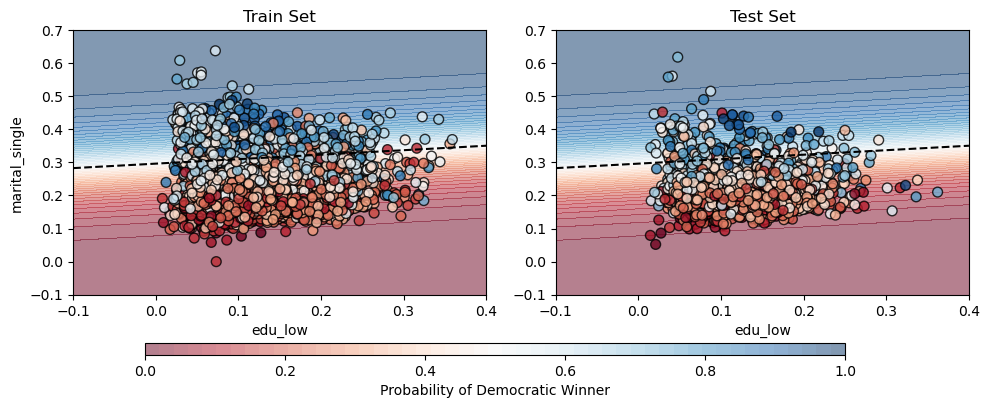

In [5]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Create meshgrid for both plots
x_min, x_max = -0.1, 0.4  # Range for edu_low
y_min, y_max = -0.1, 0.7  # Range for marital_single

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict_proba(grid_points)[:, 1]
Z = Z.reshape(xx.shape)

# Plot training set
contour1 = ax1.contourf(xx, yy, Z, alpha=0.5, levels=np.linspace(0, 1, 50), cmap='RdBu')
ax1.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--')
scatter1 = ax1.scatter(X_train['edu_low'], X_train['marital_single'], 
                      c=df_train['dem'], cmap='RdBu', 
                      s=50, edgecolor='k', alpha=0.8)
ax1.set_xlabel('edu_low')
ax1.set_ylabel('marital_single')
ax1.set_title('Train Set')

# Plot test set
contour2 = ax2.contourf(xx, yy, Z, alpha=0.5, levels=np.linspace(0, 1, 50), cmap='RdBu')
ax2.contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--')
scatter2 = ax2.scatter(X_test['edu_low'], X_test['marital_single'], 
                      c=df_test['dem'], cmap='RdBu', 
                      s=50, edgecolor='k', alpha=0.8)
ax2.set_xlabel('edu_low')
ax2.set_title('Test Set')

# Set identical axis limits for both plots
for ax in [ax1, ax2]:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

# Add a horizontal colorbar at the bottom
plt.subplots_adjust(bottom=0.2)  # Make room for the colorbar
cax = fig.add_axes([0.15, 0.1, 0.7, 0.03])  # [left, bottom, width, height]
cbar = plt.colorbar(contour1, cax=cax, orientation='horizontal', 
                   ticks=np.arange(0, 1.2, 0.2), label='Probability of Democratic Winner')

plt.tight_layout()
# add space for the colorbar
plt.subplots_adjust(bottom=0.25)
plt.show()


### Interpretation using log odds
We can interpret the logistic regression model in terms of **log odds**. Recall that the odds of an event $A$ is defined as
\begin{equation*}
    \text{odds}(A) = \frac{\Pr(A)}{1 - \Pr(A)}.
\end{equation*}
The log odds are then defined as
\begin{equation*}
    \text{log odds}(A) = \log(\text{odds}(A)) = \log\left(\frac{\Pr(A)}{1 - \Pr(A)}\right).
\end{equation*}
Now, in our case, the output of the logistic regression model is given by
\begin{equation*}
    p(1 \mid \vec{x}) =  \frac{1}{1 + \exp(-z)}.
\end{equation*}
Solving for $z$, we get
\begin{equation*}
    z = \log\left(\frac{p(1 \mid \vec{x})}{1 - p(1 \mid \vec{x})}\right) = \log\left(\frac{p(1 \mid \vec{x})}{p(0 \mid \vec{x})}\right).
\end{equation*}
Thus, we can interpret the logistic regression model as a *linear regression model*, in which the target is not the probability of being in class $1$, but rather the log odds of being in class $1$:
\begin{equation*}
    z = \vec{w} \cdot \vec{x} + b = \log\left(\frac{p(1 \mid \vec{x})}{p(0 \mid \vec{x})}\right).
\end{equation*}

## Softmax regression

### Setup for multi-class classification
Recall that when we have a multi-class classification problem, then we have a labelled dataset with the following setup:
- There are $m$ instances in the dataset.
- There are $n$ features $X_i$, each corresponding to a column vector $\mathbf{x}_i \in \mathbb{R}^m$.
- There is a single target $Y$ which takes the value $0,1,\ldots,k-1$ for each instance (i.e. The set of possible classes is encoded as $\mathcal{C} = \{0,1,\dotsc,k-1\}$). The target is represented by a column vector $\mathbf{y} \in \{0,1,\ldots,k-1\}^m$.

A hard classifier would output a single class label $c \in \mathcal{C}$ for each instance $\vec{x}$: 
\begin{equation*}
    F_{\textup{hard}} : \mathbb{R}^n \to \mathcal{C}.
\end{equation*}
A soft classifier, on the other hand, would output a **probability vector** $(p_0,p_1,\ldots,p_{k-1})$, where $p_i$ is the probability that the instance belongs to class $i$. Note that giving such a probability vector is equivalent to specifying a probability distribution over the set of classes $\mathcal{C}$. Thus, we can write the soft classifier as a function:
\begin{align*}
    F_{\textup{soft}} : \mathbb{R}^n &\to \Delta_k,\\
    \vec{x} &\mapsto (p_0,p_1,\ldots,p_{k-1}),
\end{align*}
where $\Delta_k$ is the **$k$-dimensional probability simplex**:
\begin{equation*}
    \Delta_k = \{(p_0,p_1,\ldots,p_{k-1}) \in \mathbb{R}^k \mid p_i \geq 0, \sum_{i=0}^{k-1} p_i = 1\}.
\end{equation*}

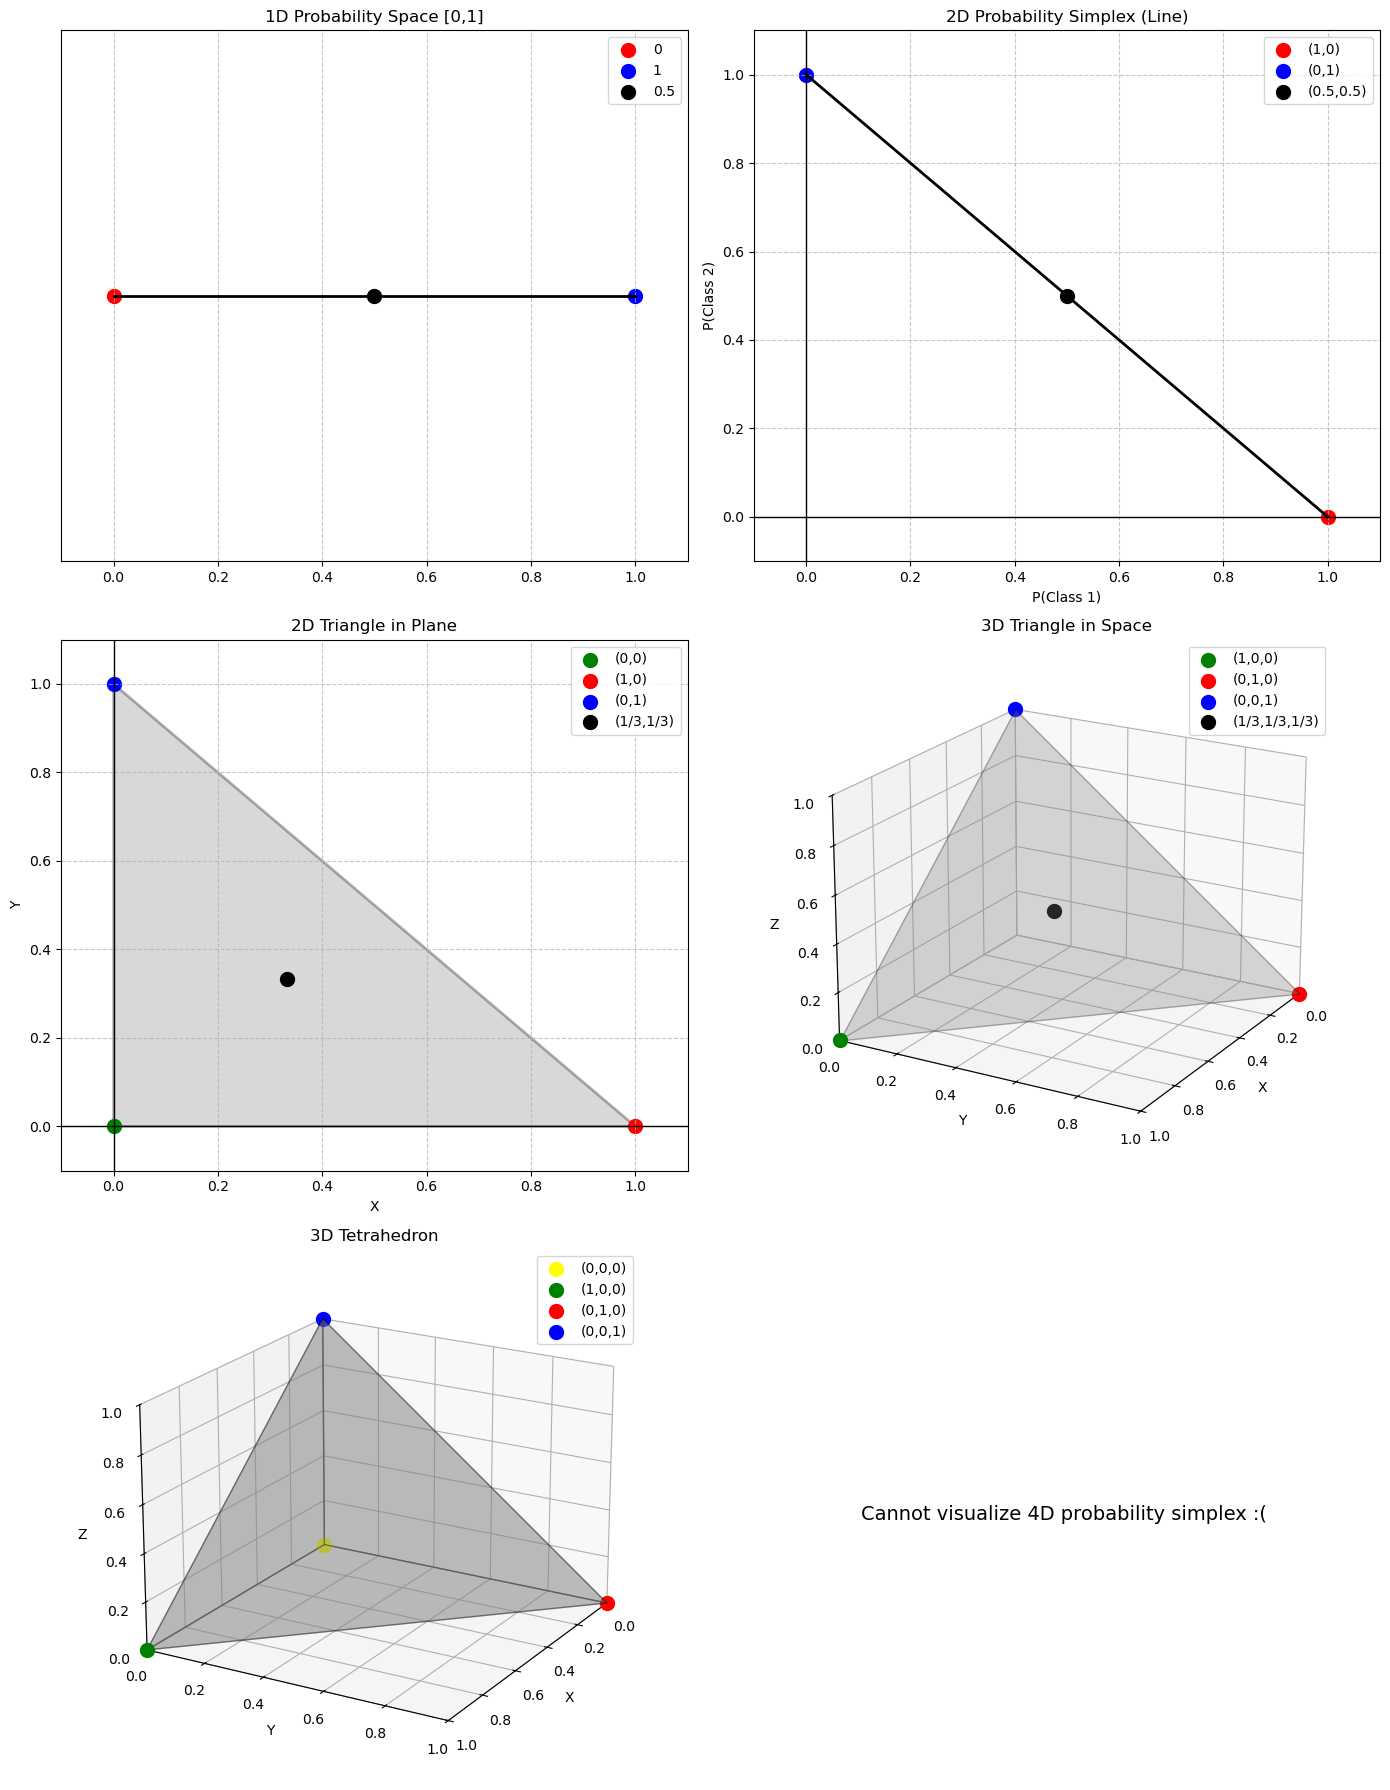

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Create a figure with 3 rows and 2 columns
fig = plt.figure(figsize=(14, 18))

# ----------------- ROW 1: 1D and 2D representations ----------------- 

# Subplot 1: 1D interval [0,1]
ax1 = fig.add_subplot(3, 2, 1)
ax1.plot([0, 1], [0, 0], 'k-', lw=2)
ax1.scatter([0], [0], color='red', s=100, label='0')
ax1.scatter([1], [0], color='blue', s=100, label='1')
ax1.scatter([0.5], [0], color='black', s=100, label='0.5')
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 0.1)
ax1.set_title('1D Probability Space [0,1]')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_yticks([])  # Hide y-axis ticks

# Subplot 2: 2D line segment from (1,0) to (0,1)
ax2 = fig.add_subplot(3, 2, 2)
ax2.plot([1, 0], [0, 1], 'k-', lw=2)
ax2.scatter([1], [0], color='red', s=100, label='(1,0)')
ax2.scatter([0], [1], color='blue', s=100, label='(0,1)')
ax2.scatter([0.5], [0.5], color='black', s=100, label='(0.5,0.5)')
# plot the axes
ax2.axhline(0, color='black', lw=1)
ax2.axvline(0, color='black', lw=1)
ax2.set_xlim(-0.1, 1.1)
ax2.set_ylim(-0.1, 1.1)
ax2.set_xlabel('P(Class 1)')
ax2.set_ylabel('P(Class 2)')
ax2.set_title('2D Probability Simplex (Line)')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)

# ----------------- ROW 2: 2D triangle and 3D triangle ----------------- 

# Subplot 3: 2D triangle
ax3 = fig.add_subplot(3, 2, 3)
vertices = np.array([
    [0, 0],    # green
    [1, 0],    # red
    [0, 1]     # blue
])
triangle = Polygon(vertices, fill=True, edgecolor='black', facecolor='gray', alpha=0.3, lw=2)
ax3.add_patch(triangle)
ax3.scatter(vertices[0, 0], vertices[0, 1], color='green', s=100, label='(0,0)')
ax3.scatter(vertices[1, 0], vertices[1, 1], color='red', s=100, label='(1,0)')
ax3.scatter(vertices[2, 0], vertices[2, 1], color='blue', s=100, label='(0,1)')
# Midpoint - centroid of the triangle
midpoint = np.mean(vertices, axis=0)
ax3.scatter(midpoint[0], midpoint[1], color='black', s=100, label='(1/3,1/3)')
# plot the axes
ax3.axhline(0, color='black', lw=1)
ax3.axvline(0, color='black', lw=1)
ax3.set_xlim(-0.1, 1.1)
ax3.set_ylim(-0.1, 1.1)
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_title('2D Triangle in Plane')
ax3.legend()
ax3.grid(True, linestyle='--', alpha=0.7)

# Subplot 4: 3D triangle
ax4 = fig.add_subplot(3, 2, 4, projection='3d')
vertices_3d = np.array([
    [1, 0, 0],    # green
    [0, 1, 0],    # red
    [0, 0, 1]     # blue
])
# Create the triangular face
triangle_3d = [vertices_3d]
poly3d = Poly3DCollection(triangle_3d, alpha=0.3, facecolor='gray', edgecolor='black', linewidth=1)
ax4.add_collection3d(poly3d)
ax4.scatter(vertices_3d[0, 0], vertices_3d[0, 1], vertices_3d[0, 2], color='green', s=100, label='(1,0,0)')
ax4.scatter(vertices_3d[1, 0], vertices_3d[1, 1], vertices_3d[1, 2], color='red', s=100, label='(0,1,0)')
ax4.scatter(vertices_3d[2, 0], vertices_3d[2, 1], vertices_3d[2, 2], color='blue', s=100, label='(0,0,1)')
# Midpoint of the triangle
midpoint_3d = np.mean(vertices_3d, axis=0)
ax4.scatter(midpoint_3d[0], midpoint_3d[1], midpoint_3d[2], color='black', s=100, label='(1/3,1/3,1/3)')
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)
ax4.set_zlim(0, 1)
ax4.set_xlabel('X')
ax4.set_ylabel('Y')
ax4.set_zlabel('Z')
ax4.set_title('3D Triangle in Space')
ax4.legend()
ax4.view_init(elev=20, azim=30)

# ----------------- ROW 3: 3D tetrahedron and empty plot ----------------- 

# Subplot 5: 3D tetrahedron
ax5 = fig.add_subplot(3, 2, 5, projection='3d')
tetrahedron_vertices = np.array([
    [0, 0, 0],    # yellow
    [1, 0, 0],    # green
    [0, 1, 0],    # red
    [0, 0, 1]     # blue
])
# Define the faces of the tetrahedron
faces = [
    [tetrahedron_vertices[0], tetrahedron_vertices[1], tetrahedron_vertices[2]],
    [tetrahedron_vertices[0], tetrahedron_vertices[1], tetrahedron_vertices[3]],
    [tetrahedron_vertices[0], tetrahedron_vertices[2], tetrahedron_vertices[3]],
    [tetrahedron_vertices[1], tetrahedron_vertices[2], tetrahedron_vertices[3]]
]
tetra = Poly3DCollection(faces, alpha=0.3, facecolor='gray', edgecolor='black', linewidth=1)
ax5.add_collection3d(tetra)
ax5.scatter(tetrahedron_vertices[0, 0], tetrahedron_vertices[0, 1], tetrahedron_vertices[0, 2], 
           color='yellow', s=100, label='(0,0,0)')
ax5.scatter(tetrahedron_vertices[1, 0], tetrahedron_vertices[1, 1], tetrahedron_vertices[1, 2], 
           color='green', s=100, label='(1,0,0)')
ax5.scatter(tetrahedron_vertices[2, 0], tetrahedron_vertices[2, 1], tetrahedron_vertices[2, 2], 
           color='red', s=100, label='(0,1,0)')
ax5.scatter(tetrahedron_vertices[3, 0], tetrahedron_vertices[3, 1], tetrahedron_vertices[3, 2], 
           color='blue', s=100, label='(0,0,1)')
ax5.set_xlim(0, 1)
ax5.set_ylim(0, 1)
ax5.set_zlim(0, 1)
ax5.set_xlabel('X')
ax5.set_ylabel('Y')
ax5.set_zlabel('Z')
ax5.set_title('3D Tetrahedron')
ax5.legend()
ax5.view_init(elev=20, azim=30)

# Subplot 6: Empty (Cannot visualize 4D)
ax6 = fig.add_subplot(3, 2, 6)
ax6.text(0.5, 0.5, "Cannot visualize 4D probability simplex :( ", 
         horizontalalignment='center', verticalalignment='center', fontsize=14)
ax6.axis('off')

plt.tight_layout()
plt.show()

### Understanding probability vectors
Let's try to understand how to visualize probability vectors as in the above image:
1. **First row, $k=2$**: 

    - In the left plot, we use a single number $p$ to represent the probability of class $1$; the probability of class $0$ is automatically forced to be $1-p$. Thus, we can represent the probability vector as a point $p \in [0,1]$.
    - The right plot visualizes the actual probability vector as a point in the 2D simplex $$\Delta_2 = \{(p_0,p_1) \in \mathbb{R}^2 \mid p_0 + p_1 = 1\},$$ which is the line segment between $(1,0)$ and $(0,1)$. 
    - Note that in the second plot, a hard classifier would be represented by a point on the corners of the simplex, i.e. $(1,0)$ represents a prediction of class $0$, and $(0,1)$ a prediction of class $1$.

2. **Second row, $k=3$**:

    - In the left plot, we use two numbers $p_1$ and $p_2$ to represent the probabilities of classes $1$ and $2$, respectively. These numbers can vary between $0$ and $1$, but their sum cannot exceed $1$; these constraints trace out the triangle. The probability of class $0$ is automatically forced to be $1-p_1-p_2$. Thus, we can represent the probability vector as a point $(p_1,p_2) \in [0,1]^2$.
    - The right plot visualizes the actual probability vector as a point in the 2D simplex $$\Delta_3 = \{(p_0,p_1,p_2) \in \mathbb{R}^3 \mid p_0 + p_1 + p_2 = 1\},$$ which is the triangle with corners $(1,0,0)$, $(0,1,0)$ and $(0,0,1)$. 
    - Note that in the second plot, a hard classifier would be represented by a point on the corners of the simplex, i.e. $(1,0,0)$ represents a prediction of class $0$, $(0,1,0)$ a prediction of class $1$, and $(0,0,1)$ a prediction of class $2$.

3. **Third row, $k=4$**:

    - In the left plot, we use three numbers $p_1$, $p_2$ and $p_3$ to represent the probabilities of classes $1$, $2$ and $3$, respectively. These numbers can vary between $0$ and $1$, but their sum cannot exceed $1$; these constraints trace out the solid tetrahedron with vertices $(0,0,0), (1,0,0), (0,1,0),$ and $(0,0,1)$. The probability of class $0$ is automatically forced to be $1-p_1-p_2-p_3$. Thus, we can represent the probability vector as a point $(p_1,p_2,p_3) \in [0,1]^3$.
    - The mid-point in the left subplot is not pictured, but it would be $(0.25,0.25,0.25)$.
    - The right plot... is empty. This is because we need 4 dimensions to visualize the full 4d probability vector! Nevertheless, we can algebraically define the 4d simplex as
    \begin{equation*}
        \Delta_4 = \{(p_0,p_1,p_2,p_3) \in \mathbb{R}^4 \mid p_0 + p_1 + p_2 + p_3 = 1\}.
    \end{equation*}
    That is, it is the solid (3d) tetrahedron in $\mathbb{R}^4$ with corners $(1,0,0,0)$, $(0,1,0,0)$, $(0,0,1,0)$ and $(0,0,0,1)$. The mid-pt would therefore be $(0.25,0.25,0.25,0.25)$.

### The softmax function

The softmax function is a generalization of the logistic function to the multi-class setting. It is defined as follows:
\begin{align*}
    S : \mathbb{R}^k &\to \Delta_k,\\
    \vec{z} &\mapsto \left(\frac{\exp(z_0)}{\sum_{i=0}^{k-1} \exp(z_i)},\ldots,\frac{\exp(z_{k-1})}{\sum_{i=0}^{k-1} \exp(z_i)}\right).
\end{align*}
We can break this down as a composition of two operations:
1. **Exponentiation**: The first operation is to exponentiate each component of the input vector $\vec{z} = (z_0,\ldots,z_{k-1})$. This gives us a new vector $\vec{z}' = (\exp(z_0),\ldots,\exp(z_{k-1}))$, in which all the entries lie in $(0,\infty)$ (i.e. they are positive). This can be understood as a mapping from $\mathbb{R}^k$ to $(0,\infty)^k$.
2. **Normalization**: The second operation is to normalize the vector $\vec{z}'$ so that its entries sum up to $1$. This gives us the final output vector $\vec{p} = (p_0,\ldots,p_{k-1})$, in which all the entries lie in $(0,1)$ and sum up to $1$. This can be understood as a mapping from $(0,\infty)^k$ to $\Delta_k$.

#### Key properties of the softmax function:
- The softmax function is a **smooth** function, i.e. it is differentiable everywhere.
- Since $\exp$ is monotinically increasing, the softmax preserves the relative order of the entries in the $\vec{z}$ vector. 
- The softmax function is **sensitive to the relative differences** between the entries in the $\vec{z}$ vector. That is, if we have two entries $z_i$ and $z_j$ such that $z_i \gg z_j$, then the softmax will assign a much higher probability to class $i$ than to class $j$. Conversely, if $z_i$ and $z_j$ are close to each other, then the softmax will assign similar probabilities to both classes.
- The softmax is **invariant to translations**. That is, if we add a constant $c$ to all the entries in the $\vec{z}$ vector, then the softmax will not change. (This is an exercise on HW 3).
- Applying softamx to any vector of the form $\vec{z} = (c,\dotsc,c)$, where $c$ is a constant, will always give the same output vector $\vec{p} = (1/k,\dotsc,1/k)$. In other words, the softmax of a constant vector is always the uniform distribution over the $k$ classes.

### Multiclass logistic regression (softmax regression)

The multiclass logistic regression model is defined analogously to the binary case, as a composition of a linear function followed by the softmax function. However, it is more complicated because the linear part is now a matrix-vector product, rather than a dot product. Let's break this down carefully:
1. **Linear part**: The linear part of the model is given by a matrix $W \in \mathbb{R}^{k \times n}$ and a bias vector $\vec{b} \in \mathbb{R}^k$. The output of the linear part is given by the matrix-vector product:
\begin{equation*}
    \vec{z} = W \vec{x} + \vec{b}.
\end{equation*}
If we write $\vec{w}_i^T \in \mathbb{R}^n$ for the $i$-th row of $W$, then we can write the above as:
\begin{align*}
    \vec{z} = \begin{bmatrix} z_0 \\ z_1 \\ \vdots \\ z_{k-1} \end{bmatrix} & = \begin{bmatrix} \vec{w}_0^T \\ \vec{w}_1^T \\ \vdots \\ \vec{w}_{k-1}^T \end{bmatrix} \vec{x} + \begin{bmatrix} b_0 \\ b_1 \\ \vdots \\ b_{k-1} \end{bmatrix} = \begin{bmatrix} \vec{w}_0 \cdot \vec{x} + b_0 \\ \vec{w}_1 \cdot \vec{x} + b_1 \\ \vdots \\ \vec{w}_{k-1} \cdot \vec{x} + b_{k-1} \end{bmatrix} \; \in \mathbb{R}^k.
\end{align*}
Thus, the linear part is a linear function with parameters $W,\vec{b}$, so we denote it as:
\begin{equation*}
    f_{W,\vec{b}}(\vec{x}) = W \vec{x} + \vec{b}.
\end{equation*}
2. **Softmax part**: The softmax part is given by the softmax function applied to the output of the linear part:
\begin{equation*}
    S(f_{W,\vec{b}}(\vec{x})) = S(W \vec{x} + \vec{b}) = S(\vec{z}).
\end{equation*}
Thus, the $j$-th entry of the output vector (for $j=0,\dotsc,k-1$) is given by:
\begin{equation*}
    p(Y=j \mid \vec{X} = \vec{x}) = \frac{\exp(z_j)}{\sum_{i=0}^{k-1} \exp(z_i)} = \frac{\exp(\vec{w}_j^T \vec{x} + b_j)}{\sum_{i=0}^{k-1} \exp(\vec{w}_i^T \vec{x} + b_i)}.
\end{equation*}
The above expression is the model's predicted probability that the instance $\vec{x}$ belongs to class $j$.
3. **Putting it all together**: The multiclass logistic regression model is then given by the composition of the linear part and the softmax part:
\begin{align*}
    L_{W,\vec{b}}(\vec{x}) &= p(Y=j \mid \vec{X} = \vec{x})\\
    &= \begin{bmatrix}
        \frac{\exp(\vec{w}_0 \cdot \vec{x} + b_0)}{\sum_{i=0}^{k-1} \exp(\vec{w}_i \cdot \vec{x} + b_i)} \\
        \vdots\\
        \frac{\exp(\vec{w}_{k-1} \cdot \vec{x} + b_{k-1})}{\sum_{i=0}^{k-1} \exp(\vec{w}_i \cdot \vec{x} + b_i)}
    \end{bmatrix}.
\end{align*}
Visually, $L_{W,\vec{b}}$ is the following composition:
\begin{equation*}
    \begin{alignedat}{4}
        \mathbb{R}^n & \xrightarrow{\; f_{W,\vec{b}} \;}  && \quad\mathbb{R}^k && \xrightarrow{\; S \; } && \; \Delta_k\\
        \vec{x} & \mapsto && \underbrace{W \vec{x} + \vec{b}}_{\vec{z}} \; && \mapsto && S(\vec{z}).
    \end{alignedat}
\end{equation*}

**Remark**: From the formulation above, it is not immediately clear how logistic regression is a special case of softmax regression with $k=2$... well, you will work out why this is true in HW 3.

### Example implementation of softmax regression
Let's implement the softmax regression model using the `LogisticRegression` class from `sklearn.linear_model` to predict wine quality in the `wine` dataset. We will use the `multi_class='multinomial'` parameter to specify that we want to use softmax regression (there are a few other "strategies" which fall under the umbrella of logistic regression for multi-class classification).

In [7]:
# read in the wine train and test sets
df_train = pd.read_csv('../data/classification/wine/train.csv')
df_test = pd.read_csv('../data/classification/wine/test.csv')

# read in the data_description dataframe
data_description = pd.read_csv('../data/classification/wine/data_description.csv')
data_description = data_description[['new_col_name','name','type']]
data_description

,new_col_name,name,type
0,Y,class,Categorical
1,X1,Alcohol,Continuous
2,X2,Malicacid,Continuous
3,X3,Ash,Continuous
4,X4,Alcalinity_of_ash,Continuous
5,X5,Magnesium,Integer
6,X6,Total_phenols,Continuous
7,X7,Flavanoids,Continuous
8,X8,Nonflavanoid_phenols,Continuous
9,X9,Proanthocyanins,Continuous


In [8]:
# make X and y matrices
X_train = df_train.drop(columns=['Y'])
y_train = df_train['Y']
X_test = df_test.drop(columns=['Y'])
y_test = df_test['Y']

# print shapes of X_train and X_test
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (142, 13)
X_test shape: (36, 13)


Model Performance Evaluation:
Accuracy: 0.9722


/opt/anaconda3/envs/math392/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


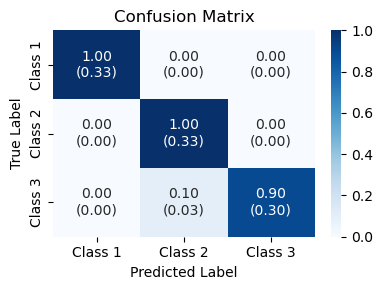

In [9]:
# Import necessary libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,  confusion_matrix

# Assuming X_train, X_test, y_train, y_test are already defined
# X_train, X_test: feature matrices with continuous variables
# y_train, y_test: target variables with classes 1, 2, or 3

# Create a pipeline that combines preprocessing and modeling steps
# This ensures that the same transformations are applied to both training and test data
pipeline = Pipeline([
    # Step 1: Standardize features to have mean=0 and variance=1
    # This is important because logistic regression is sensitive to feature scales
    ('scaler', StandardScaler()),
    
    # Step 2: Apply multinomial logistic regression
    # multi_class='multinomial' enables softmax regression (generalizes to >2 classes)
    # solver='lbfgs' is recommended for multinomial logistic regression
    ('classifier', LogisticRegression(multi_class='multinomial', 
                                      solver='lbfgs', 
                                      max_iter=1000, 
                                      random_state=42))
])

# Train the pipeline on training data
pipeline.fit(X_train, y_train)

# Make predictions on test data
y_pred = pipeline.predict(X_test)

# Calculate prediction probabilities (useful for ROC curves or calibration)
y_pred_proba = pipeline.predict_proba(X_test)

# Evaluate the model
print("Model Performance Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Visualize confusion matrix (normalized by counts of true labels)
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(4,3))
total = np.sum(cm)
# Create annotation labels containing the value and its fraction of total predictions.
labels = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        labels[i, j] = f"{cm[i,j]:.2f}\n({cm[i,j]/total:.2f})"
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues', 
            xticklabels=['Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 1', 'Class 2', 'Class 3'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [10]:
# Access individual components of the pipeline
# For example, to see the coefficients of the logistic regression model:
coefficients = pipeline.named_steps['classifier'].coef_
feature_importance = np.abs(coefficients)

# print feature importance
print("Feature Importance:")
for feature, importance in zip(X_train.columns, feature_importance[0]):
    print(f"{feature}: {importance:.4f}")

# If you want to transform new data using only the scaler:
# X_new_scaled = pipeline.named_steps['scaler'].transform(X_new)

# To save the entire pipeline for future use:
# from joblib import dump, load
# dump(pipeline, 'multinomial_logistic_pipeline.joblib')
# Later, you can load it: pipeline = load('multinomial_logistic_pipeline.joblib')

Feature Importance:
X1: 0.7175
X2: 0.1676
X3: 0.4601
X4: 0.8351
X5: 0.0386
X6: 0.2265
X7: 0.7053
X8: 0.1083
X9: 0.1254
X10: 0.2202
X11: 0.0753
X12: 0.7002
X13: 0.9265


### But what about the loss function??

In our discussion above, we did not mention at all how to go about actually fitting a logistic/softmax regression model for classification. In fact, we did not even mention the loss function!

In the case of soft classification, we want a loss function that compares the predicted probability distribution to some "true" probability distribution. Such a concept is provided by the **cross-entropy** between two probability distributions... which we will cover in the next notebook as part of a broader discussion of *information theory*.